<a href="https://colab.research.google.com/github/maxpilling/AI/blob/master/image_caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP5623 Coursework on Image Caption Generation



## Text preparation 

We need to build a vocabulary.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Mounted Drive if using Colab; otherwise, your local path
root = "drive/My Drive/Colab Notebooks/CW2/data/Flickr8k/" # <--- replace this with your root data directory
caption_dir = root + "captions/"                       # <--- replace these too
image_dir = root + "images/"                           # <---


token_file = "Flickr8k.token.txt"

A helper function to read in our ground truth text file.

In [ ]:
def read_lines(filepath):
    """ Open the ground truth captions into memory, line by line. """
    file = open(filepath, 'r')
    lines = []

    while True: 
        # Get next line from file until there's no more
        line = file.readline() 
        if not line: 
            break
        lines.append(line.strip())
    file.close() 
    return lines

You can read all the ground truth captions (5 per image), into memory as follows:

In [ ]:
lines = read_lines(caption_dir + token_file)

In [ ]:
lines[:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

In [ ]:
class Vocabulary(object):
    """Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # Intially, set both the IDs and words to empty dictionaries.
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        # If the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # Increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # If we try to access a word in the dictionary which does not exist, return the <unk> id
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

Extract all the words from ```lines```, and create a list of them in a variable ```words```, for example:

```words = ["a", "an", "the", "cat"... ]```

No need to worry about duplicates.


In [ ]:
import string
table = str.maketrans('', '', string.punctuation)
words = []

for line in lines:
  image_id, caption = line.split('\t')
  cleaned_words = [word.lower().translate(table) for word in caption.split()]
  for word in cleaned_words:
    if not word == "":
      words.append(word)

Build the vocabulary.

In [ ]:
# Create a vocab instance
vocab = Vocabulary()

# Add the token words first
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')

Add the rest of the words from the parsed captions:

``` vocab.add_word('new_word')```

Don't add words that appear three times or less.

In [ ]:
checked_words = []
for word in words:
  if not word in checked_words:
    checked_words.append(word)
    if words.count(word)>3:
      vocab.add_word(word)

In [ ]:
len(vocab)

3440

## Dataset and loaders for training

Keeping the same order, concatenate all the cleaned words from each caption into a string again, and add them all to a list of strings ```cleaned_captions```. Store all the image ids in a list ```image_ids```.

In [ ]:
import string
table = str.maketrans('', '', string.punctuation)
cleaned_captions = []
image_ids = []
i = 0
for line in lines:
  image_id, caption = line.split('\t')
  cleaned_words = [word.lower().translate(table) for word in caption.split()]
  
  cleaned_caption = " ".join(" ".join(cleaned_words).split())
  if i<5:
    print(cleaned_caption)
    i += 1
  cleaned_captions.append(cleaned_caption)
  image_ids.append(image_id[:-6])

a child in a pink dress is climbing up a set of stairs in an entry way
a girl going into a wooden building
a little girl climbing into a wooden playhouse
a little girl climbing the stairs to her playhouse
a little girl in a pink dress going into a wooden cabin


The dataframe for the image paths and captions.

In [ ]:
import pandas as pd

data = {
    'image_id': image_ids,
    'path': [image_dir + image_id + ".jpg" for image_id in image_ids],
    'caption': cleaned_captions
}

data_df = pd.DataFrame(data, columns=['image_id', 'path', 'caption'])

In [ ]:
data_df.head(n=5)

,image_id,path,caption
0,1000268201_693b08cb0e,drive/My Drive/Colab Notebooks/CW2/data/Flickr...,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e,drive/My Drive/Colab Notebooks/CW2/data/Flickr...,a girl going into a wooden building
2,1000268201_693b08cb0e,drive/My Drive/Colab Notebooks/CW2/data/Flickr...,a little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e,drive/My Drive/Colab Notebooks/CW2/data/Flickr...,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e,drive/My Drive/Colab Notebooks/CW2/data/Flickr...,a little girl in a pink dress going into a woo...


This is the Flickr8k class for the dataset.

In [ ]:
from PIL import Image
import cv2
from nltk import tokenize
from torch.utils.data import Dataset

class Flickr8k(Dataset):
    """ Flickr8k custom dataset compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, vocab, transform=None):
        """ Set the path for images, captions and vocabulary wrapper.
        
        Args:
            df: df containing image paths and captions.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.df = df
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """ Returns one data pair (image and caption). """

        vocab = self.vocab

        caption = self.df['caption'][index]
        img_id = self.df['image_id'][index]
        path = self.df['path'][index]

        image = Image.open(open(path, 'rb'))

        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = caption.split()
        caption = []
        # Build the Tensor version of the caption, with token words
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.df)

We need to overwrite the default PyTorch ```collate_fn()``` because our ground truth captions are sequential data of varying lengths. The default ```collate_fn()``` does not support merging the captions with padding.

You can read more about it here: https://pytorch.org/docs/stable/data.html#dataloader-collate-fn. 

In [ ]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

Now we define the data transform.

In [ ]:
from torchvision import transforms

# Crop size matches the input dimensions expected by the pre-trained ResNet
data_transform = transforms.Compose([ 
    transforms.Resize(224),
    transforms.CenterCrop(224),  # Why do we choose 224 x 224?
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # Using ImageNet norms
                         (0.229, 0.224, 0.225))])

Initialising the datasets. The only twist is that every image has 5 ground truth captions, so each image appears five times in the dataframe. We don't want an image to appear in more than one set.

In [ ]:
unit_size = 5

train_split = 0.95 # Defines the ratio of train/test data.

# We didn't shuffle the dataframe yet so this works
train_size = unit_size * round(len(data_df)*train_split / unit_size)

dataset_train = Flickr8k(
    df=data_df[:train_size].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

dataset_test = Flickr8k(
    df=data_df[(train_size):].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

Write the dataloaders ```train_loader``` and ```test_loader``` - explicitly replacing the collate_fn:

```train_loader = torch.utils.data.DataLoader(
  ...,
  collate_fn=caption_collate_fn
)```

Set train batch size to 128 and be sure to set ```shuffle=True```

In [ ]:
import torch

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=128,
    shuffle=True,
    collate_fn=caption_collate_fn
)

test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=caption_collate_fn
)

## Encoder and decoder models

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True) # Pre-trained on ImageNet by default
        layers = list(resnet.children())[:-1]      # Keep all layers except the last one
        # Unpack the layers and create a new Sequential
        self.resnet = nn.Sequential(*layers)
        
        # We want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 1000)
        # into a Linear layer to resize
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        
        # Batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        
        # Complete graph here. Remember to put the ResNet layer in a with torch.no_grad() block
        with torch.no_grad():
          features = self.resnet(images)

        features = features.reshape(features.size(0), -1)
        features = self.linear(features)
        features = self.bn(features)

        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        
        # What is an embedding layer?
        self.embed = nn.Embedding(vocab_size, embed_size)

        # Define this layer (one at a time)
        # self.lstm / self.rnn
        self.rnn = nn.RNN(
            input_size=embed_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        # What is "packing" a padded sequence?
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.rnn(packed) # Replace with self.rnn when using RNN
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            # hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            hiddens, states = self.rnn(inputs, states) # Replace with self.rnn when using RNN
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

class DecoderLSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderLSTM, self).__init__()
        
        # What is an embedding layer?
        self.embed = nn.Embedding(vocab_size, embed_size)

        # Define this layer (one at a time)
        # self.lstm / self.rnn
        self.lstm = nn.LSTM(
            input_size=embed_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        # What is "packing" a padded sequence?
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        
        hiddens, _ = self.lstm(packed)  # Replace with self.rnn when using RNN
        
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):

            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)

            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Set training parameters.

In [ ]:
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 5
log_step = 10
save_step = 10

Initialize the models and set the learning parameters.

In [ ]:
import numpy as np

# Build the models
""" Pick DecoderRNN or DecoderLSTM here """
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderLSTM(embed_size, hidden_size, len(vocab), num_layers).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimisation will be on the parameters of BOTH the enocder and decoder,
# but excluding the ResNet parameters, only the new added layers.
params = list(
    decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters()
)

optimizer = torch.optim.Adam(params, lr=learning_rate)


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


## Training the model

The loop to train the model. Feel free to put this in a function if you prefer.

In [ ]:
model_path = "drive/My Drive/models/"

In [ ]:
def train_model(model="RNN"):
  """ Train the models """
  torch.save(decoder.state_dict(), model_path + '{}-decoder-{}.ckpt'.format(model, 0))
  torch.save(encoder.state_dict(), model_path + '{}-encoder-{}.ckpt'.format(model, 0))
  total_step = len(train_loader)
  for epoch in range(num_epochs):
      for i, (images, captions, lengths) in enumerate(train_loader):

        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)

        # Packed as well as we'll compare to the decoder outputs
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)

        loss = criterion(outputs, targets)
        
        # Zero gradients for both networks
        decoder.zero_grad()
        encoder.zero_grad()

        loss.backward()
        optimizer.step()

        # Print log info for each iteration too
        # print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  # .format(epoch, num_epochs, i, total_step, loss.item()), end="\r")

        # Print log info
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch, num_epochs, i, total_step, loss.item())) 

        # If you want to save the model checkpoints - recommended once you have everything working
        # Make sure to save RNN and LSTM versions separately
        if (i+1) % save_step == 0:
          torch.save(decoder.state_dict(), model_path + '{}-decoder-{}.ckpt'.format(model, epoch+1))
          torch.save(encoder.state_dict(), model_path + '{}-encoder-{}.ckpt'.format(model, epoch+1))

      # Save at the end of the epoch for testing
      torch.save(decoder.state_dict(), model_path + '{}-decoder-{}.ckpt'.format(model, epoch+1))
      torch.save(encoder.state_dict(), model_path + '{}-encoder-{}.ckpt'.format(model, epoch+1))

### Using pandas instead of datastream for the test set


In [ ]:
test_set_df = data_df[(train_size):].reset_index(drop=True)

In [ ]:
test_set_df

,image_id,path,caption
0,537532165_e4b7c0e61a,drive/My Drive/Colab Notebooks/CW2/data/Flickr...,a child playing on the monkey bars at a playgr...
1,537532165_e4b7c0e61a,drive/My Drive/Colab Notebooks/CW2/data/Flickr...,a girl hangs on the bars
2,537532165_e4b7c0e61a,drive/My Drive/Colab Notebooks/CW2/data/Flickr...,a kid hangs upside down on the monkey bars at ...
3,537532165_e4b7c0e61a,drive/My Drive/Colab Notebooks/CW2/data/Flickr...,a young children hanging upside at the playground
4,537532165_e4b7c0e61a,drive/My Drive/Colab Notebooks/CW2/data/Flickr...,girl hanging upside down on blue monkey bars
...,...,...,...
2020,997722733_0cb5439472,drive/My Drive/Colab Notebooks/CW2/data/Flickr...,a man in a pink shirt climbs a rock face
2021,997722733_0cb5439472,drive/My Drive/Colab Notebooks/CW2/data/Flickr...,a man is rock climbing high in the air
2022,997722733_0cb5439472,drive/My Drive/Colab Notebooks/CW2/data/Flickr...,a person in a red shirt climbing up a rock fac...
2023,997722733_0cb5439472,drive/My Drive/Colab Notebooks/CW2/data/Flickr...,a rock climber in a red shirt


Getting two different random images and the assosciated captions

In [ ]:
import matplotlib.pyplot as plt
def get_image_and_captions(id):
  captions = test_set_df.loc[test_set_df['image_id'] == id]['caption'].tolist()
  path = test_set_df.loc[test_set_df['image_id'] == id]['path'].tolist()[0]
  image = plt.imread(path)
  return image, captions

In [ ]:
id1 = ''
id2 = ''
while id1 == id2:
  id1, id2 = test_set_df.sample(2)['image_id']

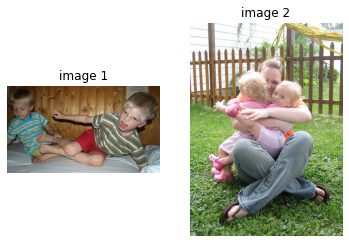

In [ ]:
id1_image, id1_captions = get_image_and_captions(id1)
id2_image, id2_captions = get_image_and_captions(id2)
plt.subplot(1,2,1)
plt.imshow(id1_image)
plt.title('image 1')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(id2_image)
plt.title('image 2')
plt.axis('off')
plt.show()

In [ ]:
def ids_to_caption(ids):
  caption = ""

  for word_id in ids:
    word = vocab.idx2word[word_id]
    if word == "<end>":
      break
    else:
      if not word == "<start>":
        caption = caption + " " + word
  return caption

def get_generated_caption(image):
  encoder.eval()
  image = transforms.ToPILImage()(image).convert("RGB")
  image = data_transform(image)
  image = image.reshape(-1, 3, 224, 224)
  image = image.to(device)
  features = encoder.forward(image)
  caption_vec = decoder.sample(features)
  ids = caption_vec.cpu().detach().numpy()[0].tolist()
  caption = ids_to_caption(ids)
  encoder.train() 
  return caption

def get_bleu_score(image, true_captions):
  from nltk.translate.bleu_score import sentence_bleu
  caption = get_generated_caption(image)
  score = sentence_bleu(true_captions, caption)
  score = format(score, '.4f')
  return score, caption

In [ ]:
def print_two_test_images():
  plt.subplot(1,2,1)
  plt.imshow(id1_image)
  plt.title('image 1')
  plt.axis('off')
  plt.subplot(1,2,2)
  plt.imshow(id2_image)
  plt.title('image 2')
  plt.axis('off')
  plt.show()

In [ ]:
def test_model_epoch(image, captions, model_name, epoch):
  decoder_name = model_path + '/' + model_name + '/' + model_name + '-decoder-' + epoch + '.ckpt'
  encoder_name = model_path + '/' + model_name + '/' + model_name + '-encoder-' + epoch + '.ckpt'
  decoder.load_state_dict(torch.load(decoder_name))
  encoder.load_state_dict(torch.load(encoder_name))

  score, caption = get_bleu_score(image, captions)
  return 'After {} epoch(s) of training | BLEU score: {} | {}'.format(epoch, score, caption)

### Training the RNN
and testing at each epoch afterwards

In [ ]:
model_path = "drive/My Drive/models/"
train_model(RNN)

Epoch [0/5], Step [0/301], Loss: 8.1581
Epoch [0/5], Step [10/301], Loss: 5.3441
Epoch [0/5], Step [20/301], Loss: 5.1537
Epoch [0/5], Step [30/301], Loss: 4.8772
Epoch [0/5], Step [40/301], Loss: 4.3728
Epoch [0/5], Step [50/301], Loss: 4.3155
Epoch [0/5], Step [60/301], Loss: 3.9097
Epoch [0/5], Step [70/301], Loss: 3.8367
Epoch [0/5], Step [80/301], Loss: 3.6393
Epoch [0/5], Step [90/301], Loss: 3.6017
Epoch [0/5], Step [100/301], Loss: 3.6410
Epoch [0/5], Step [110/301], Loss: 3.5821
Epoch [0/5], Step [120/301], Loss: 3.6290
Epoch [0/5], Step [130/301], Loss: 3.4834
Epoch [0/5], Step [140/301], Loss: 3.4879
Epoch [0/5], Step [150/301], Loss: 3.3378
Epoch [0/5], Step [160/301], Loss: 3.3196
Epoch [0/5], Step [170/301], Loss: 3.3860
Epoch [0/5], Step [180/301], Loss: 3.5497
Epoch [0/5], Step [190/301], Loss: 3.2332
Epoch [0/5], Step [200/301], Loss: 3.2505
Epoch [0/5], Step [210/301], Loss: 3.1261
Epoch [0/5], Step [220/301], Loss: 3.1433
Epoch [0/5], Step [230/301], Loss: 3.2351
Epo

#### Testing the RNN at each epoch


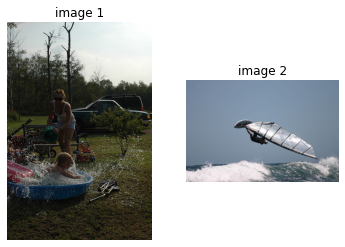

Left image:
After 0 epoch(s) of training | BLEU score: 0.1863 |  chopsticks union stunts dollar hugging taken kayaks apart opponent jeep onlookers paws ridden covers french acting used suv dinner bleachers
After 1 epoch(s) of training | BLEU score: 0.4528 |  a boy in a red shirt is standing in a park
After 2 epoch(s) of training | BLEU score: 0.4325 |  a young boy in a yellow kayak is running through the snow
After 3 epoch(s) of training | BLEU score: 0.4599 |  a young boy in a red shirt is standing on a rock
After 4 epoch(s) of training | BLEU score: 0.4762 |  a boy in a blue shirt is jumping off a swing
After 5 epoch(s) of training | BLEU score: 0.6056 |  a young boy in a swimsuit is jumping into a pool
Right image:
After 0 epoch(s) of training | BLEU score: 0.1427 |  corn seal snow booths jesus master smaller strewn 4 jackson records boxing shoreline blocks uncut dangling offering motion except
After 1 epoch(s) of training | BLEU score: 0.6916 |  a man is doing a trick on a ramp
Aft

In [ ]:
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)
print_two_test_images()
print('Left image:')
for epoch in range(6):
  print(test_model_epoch(id1_image, id1_captions, 'RNN', str(epoch)))
print('Right image:')
for epoch in range(6):
  print(test_model_epoch(id2_image, id2_captions, 'RNN', str(epoch)))

### Training the LSTM
and testing at each epoch afterwards

In [ ]:
train_model(model='LSTM')

Epoch [0/5], Step [0/301], Loss: 8.1548
Epoch [0/5], Step [10/301], Loss: 5.5472
Epoch [0/5], Step [20/301], Loss: 5.0821
Epoch [0/5], Step [30/301], Loss: 4.6817
Epoch [0/5], Step [40/301], Loss: 4.1601
Epoch [0/5], Step [50/301], Loss: 4.0834
Epoch [0/5], Step [60/301], Loss: 4.0571
Epoch [0/5], Step [70/301], Loss: 4.0171
Epoch [0/5], Step [80/301], Loss: 3.8026
Epoch [0/5], Step [90/301], Loss: 3.6584
Epoch [0/5], Step [100/301], Loss: 3.6834
Epoch [0/5], Step [110/301], Loss: 3.5273
Epoch [0/5], Step [120/301], Loss: 3.5117
Epoch [0/5], Step [130/301], Loss: 3.5826
Epoch [0/5], Step [140/301], Loss: 3.3384
Epoch [0/5], Step [150/301], Loss: 3.4664
Epoch [0/5], Step [160/301], Loss: 3.4724
Epoch [0/5], Step [170/301], Loss: 3.3201
Epoch [0/5], Step [180/301], Loss: 3.2330
Epoch [0/5], Step [190/301], Loss: 3.3083
Epoch [0/5], Step [200/301], Loss: 3.3692
Epoch [0/5], Step [210/301], Loss: 3.2808
Epoch [0/5], Step [220/301], Loss: 3.3232
Epoch [0/5], Step [230/301], Loss: 3.2700
Epo

#### Testing the LSTM at each epoch

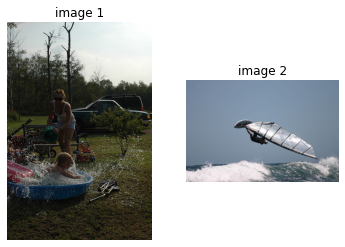

Left image:
After 0 epoch(s) of training | BLEU score: 0.2741 |  lightcolored fell throw nightclub hovers unique classroom grins cones wakeboarder sleeps inground terrain kicking wedding offering husky desert elder asking
After 1 epoch(s) of training | BLEU score: 0.4939 |  a man in a red shirt is riding a trick on a rock
After 2 epoch(s) of training | BLEU score: 0.5824 |  a young boy in a blue shirt is jumping into a pool
After 3 epoch(s) of training | BLEU score: 0.4746 |  a little boy is jumping into a pool
After 4 epoch(s) of training | BLEU score: 0.5455 |  a boy in a blue shirt is jumping into a pool
After 5 epoch(s) of training | BLEU score: 0.3851 |  a young boy is jumping into a pool
Right image:
After 0 epoch(s) of training | BLEU score: 0.1440 |  pirates wild colorfully jeans numerous 2 shirts wind sunshade obstacles lambs lambs carries wires training marker tray recording candy straps
After 1 epoch(s) of training | BLEU score: 0.4643 |  a man in a red shirt is riding a roc

In [ ]:
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderLSTM(embed_size, hidden_size, len(vocab), num_layers).to(device)
print_two_test_images()
print('Left image:')
for epoch in range(6):
  print(test_model_epoch(id1_image, id1_captions, 'LSTM', str(epoch)))
print('Right image:')
for epoch in range(6):
  print(test_model_epoch(id2_image, id2_captions, 'LSTM', str(epoch)))

## Comparing RNN to LSTM

### Test on all of test set

In [ ]:
def test_model_epoch(image, captions, model_name, epoch):
  decoder_name = model_path + '/' + model_name + '/' + model_name + '-decoder-' + epoch + '.ckpt'
  encoder_name = model_path + '/' + model_name + '/' + model_name + '-encoder-' + epoch + '.ckpt'
  decoder.load_state_dict(torch.load(decoder_name))
  encoder.load_state_dict(torch.load(encoder_name))

  score, caption = get_bleu_score(image, captions)
  return 'After {} epoch(s) of training | BLEU score: {} | {}'.format(epoch, score, caption)

In [ ]:
def test_model_all(model_name, epoch="5"):
  decoder_name = model_path + '/' + model_name + '/' + model_name + '-decoder-' + epoch + '.ckpt'
  encoder_name = model_path + '/' + model_name + '/' + model_name + '-encoder-' + epoch + '.ckpt'
  decoder.load_state_dict(torch.load(decoder_name))
  encoder.load_state_dict(torch.load(encoder_name))

  # Sort the images so a new image is every 5th element
  sorted_df = test_set_df.sort_values('image_id')

  ids = []
  scores = []
  captions = []
  for i in range(0, int(len(sorted_df.index)/5)):
    # Getting a particular image and its captions
    row_num = int(5*i)

    image_id = sorted_df.iloc[row_num]['image_id']
    path = image_dir + image_id + ".jpg"
    image = plt.imread(path)

    real_captions = sorted_df.iloc[row_num:row_num+5]['caption'].tolist()

    # Testing on that image
    score, caption = get_bleu_score(image, real_captions)

    ids.append(image_id)
    scores.append(score)
    captions.append(caption)
  
  test_data = {
      'image_id': ids,
      'BLEU_score': scores,
      'caption': captions
  }

  return pd.DataFrame(test_data, columns=['image_id', 'BLEU_score', 'caption'])

In [ ]:
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)
rnn_test_results_df = test_model_all(model_name="RNN")
rnn_test_results_df

,image_id,BLEU_score,caption
0,537532165_e4b7c0e61a,0.4026,a young boy is jumping on a trampoline
1,537559285_29be110134,0.6747,a dog jumps over a hurdle
2,537579448_a7f92cef58,0.4712,a little boy in a blue shirt is running on a ...
3,537628742_146f2c24f8,0.4360,a man and a dog are standing on a sidewalk
4,537758332_8beb9cf522,0.2527,a boy is jumping on a trampoline
...,...,...,...
400,990890291_afc72be141,0.6267,a young boy is riding a bicycle down a ramp
401,99171998_7cc800ceef,0.6376,a group of people are standing on a rocky cli...
402,99679241_adc853a5c0,0.5007,a white bird flies through the air
403,997338199_7343367d7f,0.5961,a man in a red shirt is standing on a bench


In [ ]:
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderLSTM(embed_size, hidden_size, len(vocab), num_layers).to(device)
lstm_test_results_df = test_model_all(model_name="LSTM")
lstm_test_results_df

,image_id,BLEU_score,caption
0,537532165_e4b7c0e61a,0.4026,a young boy is jumping on a trampoline
1,537559285_29be110134,0.6747,a dog jumps over a hurdle
2,537579448_a7f92cef58,0.4875,a little boy in a red shirt is running throug...
3,537628742_146f2c24f8,0.6453,a man is standing on a sidewalk with a mounta...
4,537758332_8beb9cf522,0.4009,a child is sitting on a rock wall
...,...,...,...
400,990890291_afc72be141,0.6305,a man in a red shirt is riding a bike on a bike
401,99171998_7cc800ceef,0.8357,a group of people are standing on a snowy mou...
402,99679241_adc853a5c0,0.7244,a white bird is flying through the water
403,997338199_7343367d7f,0.3354,a man in a white shirt is sitting on a bench ...


In [ ]:
def get_test_results(test_results_df):
  
  test_scores = test_results_df[['BLEU_score']].apply(pd.to_numeric) 
  mean = test_scores.mean()[0]
  standard_deviation = test_scores.std()[0]

  return mean, standard_deviation

In [ ]:
rnn_mean, rnn_std = get_test_results(rnn_test_results_df)
lstm_mean, lstm_std = get_test_results(lstm_test_results_df)

In [ ]:
print('{}: mean={:.4f}, standard deviation={:.4f}'.format("RNN ", rnn_mean, rnn_std))
print('{}: mean={:.4f}, standard deviation={:.4f}'.format("LSTM", lstm_mean, lstm_std))

RNN : mean=0.5407, standard deviation=0.1719
LSTM: mean=0.5719, standard deviation=0.1570


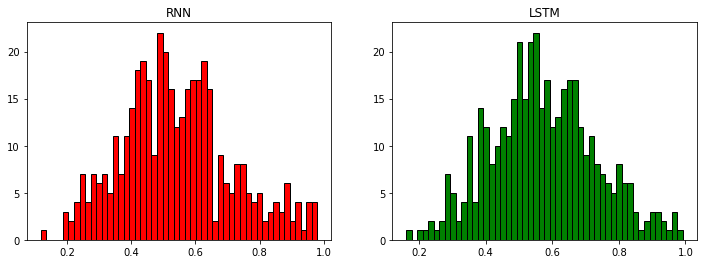

In [ ]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1)
ax1.title.set_text('RNN')
plt.hist(x=pd.to_numeric(rnn_test_results_df['BLEU_score']), bins=50, alpha = 1, color="red", edgecolor='black')
ax2 = plt.subplot(1,2,2)
ax2.title.set_text('LSTM')
plt.hist(x=pd.to_numeric(lstm_test_results_df['BLEU_score']), bins=50, alpha = 1, color="green", edgecolor='black')
plt.show()

### Quality of captions

In [ ]:
def get_best_and_worst_four(model):
  if model=="RNN":
    test_results_df = rnn_test_results_df
  elif model=="LSTM":
    test_results_df = lstm_test_results_df
  test_results_df = test_results_df.sort_values('BLEU_score', ascending=False)
  best_five_df = test_results_df.head(4)
  worst_five_df = test_results_df.tail(4)
  return best_five_df, worst_five_df

In [ ]:
best_four_df, worst_four_df = get_best_and_worst_four("RNN")

In [ ]:
def plot_worst_or_best(type):
  if type=="worst":
    four_ids      = worst_four_df['image_id'].to_list()
    four_captions = worst_four_df['caption'].to_list()
    four_scores   = worst_four_df['BLEU_score'].to_list()
  elif type=="best":
    four_ids      = best_four_df['image_id'].to_list()
    four_captions = best_four_df['caption'].to_list()
    four_scores   = best_four_df['BLEU_score'].to_list()
  plt.figure(figsize=(12,8))
  for i, (id, caption, score) in enumerate(zip(four_ids,four_captions,four_scores)):
    ax = plt.subplot(2,2,i+1)
    ax.title.set_text("{} | {}".format(score,caption))
    plt.axis('off')
    path = test_set_df.loc[test_set_df['image_id'] == id]['path'].tolist()[0]
    image = plt.imread(path)
    plt.imshow(image)
  plt.show()

RNN 4 worst


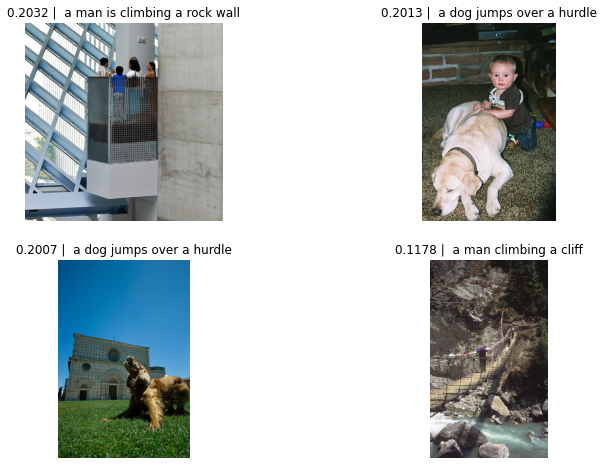

RNN 4 best


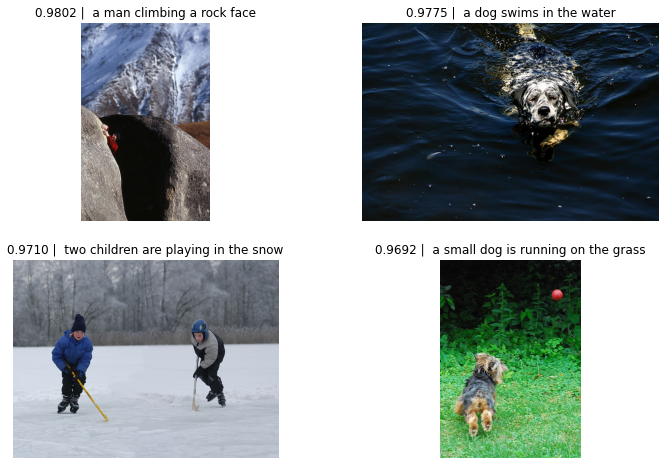

In [ ]:
best_four_df, worst_four_df = get_best_and_worst_four("RNN")
print('RNN 4 worst')
plot_worst_or_best("worst")
print('RNN 4 best')
plot_worst_or_best("best")

LSTM 4 worst


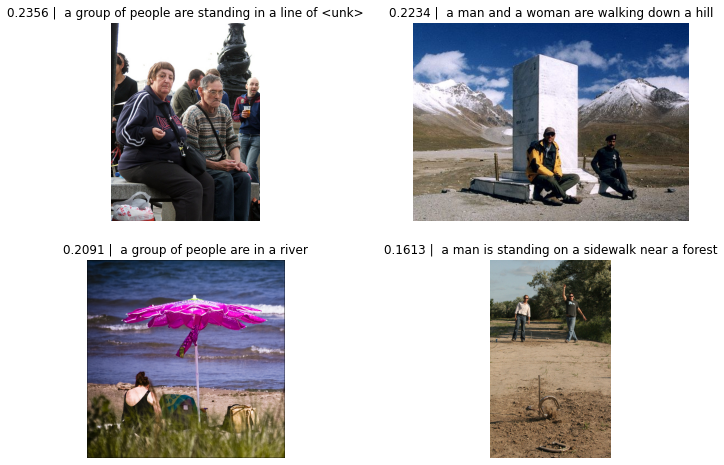

LSTM 4 best


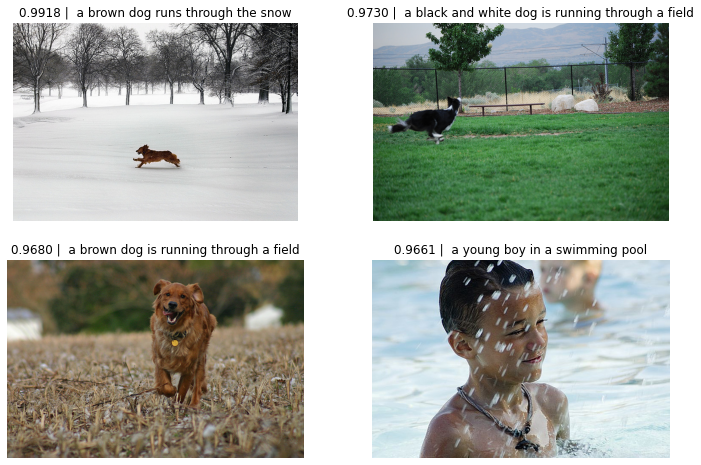

In [ ]:
best_four_df, worst_four_df = get_best_and_worst_four("LSTM")
print('LSTM 4 worst')
plot_worst_or_best("worst")
print('LSTM 4 best')
plot_worst_or_best("best")

### Long and short captions

#### Testing generated captions lengths

In [ ]:
def get_long_short_results(test_results_df):

  long_short_df = test_results_df
  long_short_df['length'] = long_short_df['caption'].str.split().apply(len)
  long_short_df = long_short_df.sort_values('length', ascending=False)

  """Lets take the longest 1/3 to be long captions
  the shortest 1/3 to be short captions
  and the rest to be average length"""
  import math
  length = len(long_short_df)
  third = math.ceil(length/3)
  long_df = long_short_df[:third]
  short_df = long_short_df[-third:]

  return long_short_df, long_df, short_df
  

I want to get the mean values for the long and short captions.

In [ ]:
rnn_long_short_df, rnn_long_df, rnn_short_df = get_long_short_results(rnn_test_results_df)
lstm_long_short_df, lstm_long_df, lstm_short_df = get_long_short_results(lstm_test_results_df)

In [ ]:
rnn_long_df.head(5)

,image_id,BLEU_score,caption,length
295,862187579_9faf4a51e0,0.5596,a man in a red shirt is standing on a street ...,18
250,804087017_330bcc8c56,0.5661,a man in a red shirt is standing on a street ...,18
186,733964952_69f011a6c4,0.4291,a man in a red shirt is standing on a sidewal...,18
302,871290666_4877e128c0,0.4881,a man in a blue shirt is standing on a street...,18
23,542179694_e170e9e465,0.4484,a man in a red shirt is standing on a street ...,18


In [ ]:
lstm_long_df.head(5)

,image_id,BLEU_score,caption,length
292,862054277_34b5a6f401,0.7389,a young girl in a pink shirt is standing in t...,19
191,745563422_f4fa7d9157,0.5489,a woman in a white shirt and a white hat is s...,19
311,881725588_efabbcd96a,0.5891,a woman in a white shirt and a white hat is s...,19
392,978580450_e862715aba,0.2785,a young girl in a pink bathing suit is standi...,19
197,749840385_e004bf3b7c,0.6425,a man in a white shirt and a black hat is sta...,19


In [ ]:
rnn_short_df.tail(5)

,image_id,BLEU_score,caption,length
333,925491651_57df3a5b36,0.7589,a dog running through water,5
148,684375286_09cc1aa778,0.3103,a dog chases a deer,5
319,895502702_5170ada2ee,0.6514,a dog running on grass,5
289,861608773_bdafd5c996,0.3111,a dog chases a ball,5
372,96399948_b86c61bfe6,0.5371,a man playing tennis,4


In [ ]:
lstm_short_df.tail(5)

,image_id,BLEU_score,caption,length
72,566921157_07c18a41e2,0.6606,a dog runs through the snow,6
333,925491651_57df3a5b36,0.8170,a dog runs through the water,6
1,537559285_29be110134,0.6747,a dog jumps over a hurdle,6
209,756909515_a416161656,0.7614,two dogs playing in the water,6
404,997722733_0cb5439472,0.8251,a man climbing a rock wall,6


In [ ]:
def print_result(current_df, name):
  current_scores = current_df[['BLEU_score']].apply(pd.to_numeric)
  current_mean = current_scores.mean()[0]
  current_std  = current_scores.std()[0]
  print('{}: mean={:.4f}, standard deviation={:.4f}'.format(name, current_mean, current_std))

In [ ]:
print_result(rnn_long_df,   'RNN long  ')
print_result(lstm_long_df,  'LSTM long ')
print_result(rnn_short_df,  'RNN short ')
print_result(lstm_short_df, 'LSTM short')

RNN long  : mean=0.5491, standard deviation=0.1249
LSTM long : mean=0.5257, standard deviation=0.1254
RNN short : mean=0.5331, standard deviation=0.2141
LSTM short: mean=0.5909, standard deviation=0.1813


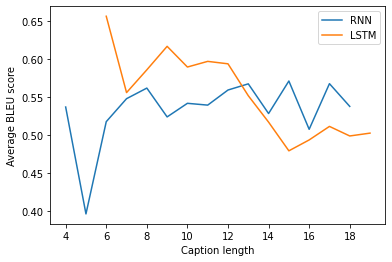

In [ ]:
rnn_length_bleu = rnn_long_short_df[['length','BLEU_score']].apply(pd.to_numeric)
rnn_length_bleu = rnn_length_bleu.groupby('length').mean()
lstm_length_bleu = lstm_long_short_df[['length','BLEU_score']].apply(pd.to_numeric)
lstm_length_bleu = lstm_length_bleu.groupby('length').mean()

plt.plot(rnn_length_bleu, label="RNN")
plt.plot(lstm_length_bleu, label="LSTM")
plt.xlabel("Caption length")
plt.ylabel("Average BLEU score")
plt.legend(loc="upper right")
plt.show()

#### Testing performance on captions that where originally long vs short
Do the networks use the same length of description?

In [ ]:
def test_on(model_name, dataset_df, epoch='5'):
  decoder_name = model_path + '/' + model_name + '/' + model_name + '-decoder-' + epoch + '.ckpt'
  encoder_name = model_path + '/' + model_name + '/' + model_name + '-encoder-' + epoch + '.ckpt'
  decoder.load_state_dict(torch.load(decoder_name))
  encoder.load_state_dict(torch.load(encoder_name))

  # Sort the images so a new image is every 5th element
  sorted_df = dataset_df.sort_values('image_id')

  ids = []
  scores = []
  captions = []
  average_lengths = []
  for i in range(0, int(len(sorted_df.index)/5)):
    # Getting a particular image and its captions
    row_num = int(5*i)

    image_id = sorted_df.iloc[row_num]['image_id']
    average_length = sorted_df.iloc[row_num]['average']
    path = image_dir + image_id + '.jpg'
    image = plt.imread(path)

    real_captions = sorted_df.iloc[row_num:row_num+5]['caption'].tolist()

    # Testing on that image
    score, caption = get_bleu_score(image, real_captions)

    ids.append(image_id)
    scores.append(score)
    captions.append(caption)
    average_lengths.append(average_length)
  
  test_data = {
      'image_id': ids,
      'BLEU_score': scores,
      'caption': captions,
      'average_length': average_lengths
  }

  return pd.DataFrame(test_data, columns=['image_id', 'BLEU_score', 'caption', 'average_length'])

In [ ]:
def long_short_idv_image(model):
  # Sort into long and short
  long_short_df, long_df, short_df = get_long_short_results(test_set_df)

def long_short_average_image(model):
  long_short_df, _, _ = get_long_short_results(test_set_df)
  
  # Need to make an extra column with average length
  long_short_df = long_short_df.sort_values('image_id')
  long_short_df['average'] = long_short_df.groupby('image_id').length.agg('mean').reindex(long_short_df.image_id).reset_index()['length']
  
  # Now split this up into long and short by taking thirds of the dataset
  long_short_df = long_short_df.sort_values('average', ascending=False)
  """Lets take the longest 1/3 to be long captions
  the shortest 1/3 to be short captions
  and the rest to be average length"""
  import math
  length = len(long_short_df)
  third = math.ceil(length/3)
  long_df = long_short_df.head(third)
  short_df = long_short_df.tail(third)

  # Long test
  long_test_df = test_on(model_name=model, dataset_df=long_df, epoch='5')

  # Short test
  short_test_df = test_on(model, short_df)

  return long_test_df, short_test_df

In [ ]:
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)
rnn_long_test_df, rnn_short_test_df = long_short_average_image('RNN')

In [ ]:
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderLSTM(embed_size, hidden_size, len(vocab), num_layers).to(device)
lstm_long_test_df, lstm_short_test_df = long_short_average_image('LSTM')

In [ ]:
rnn_mean, rnn_std = get_test_results(rnn_long_test_df)
lstm_mean, lstm_std = get_test_results(lstm_long_test_df)
print('For the long test')
print('{}: mean={:.4f}, standard deviation={:.4f}'.format("RNN ", rnn_mean, rnn_std))
print('{}: mean={:.4f}, standard deviation={:.4f}'.format("LSTM", lstm_mean, lstm_std))

For the long test
RNN : mean=0.5185, standard deviation=0.1485
LSTM: mean=0.5791, standard deviation=0.1434


In [ ]:
rnn_mean, rnn_std = get_test_results(rnn_short_test_df)
lstm_mean, lstm_std = get_test_results(lstm_short_test_df)
print('For the short test')
print('{}: mean={:.4f}, standard deviation={:.4f}'.format("RNN ", rnn_mean, rnn_std))
print('{}: mean={:.4f}, standard deviation={:.4f}'.format("LSTM", lstm_mean, lstm_std))

For the short test
RNN : mean=0.5300, standard deviation=0.1655
LSTM: mean=0.5367, standard deviation=0.1614


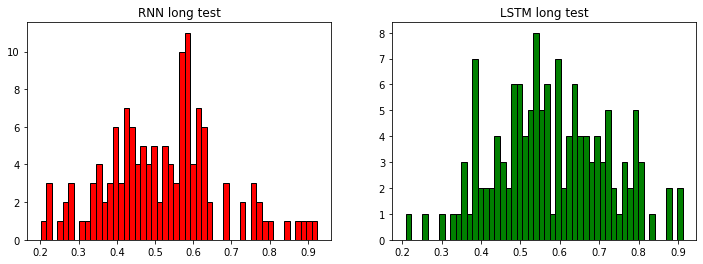

In [ ]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1)
ax1.title.set_text('RNN long test')
plt.hist(x=pd.to_numeric(rnn_long_test_df['BLEU_score']), bins=50, alpha = 1, color="red", edgecolor='black')
ax2 = plt.subplot(1,2,2)
ax2.title.set_text('LSTM long test')
plt.hist(x=pd.to_numeric(lstm_long_test_df['BLEU_score']), bins=50, alpha = 1, color="green", edgecolor='black')
plt.show()

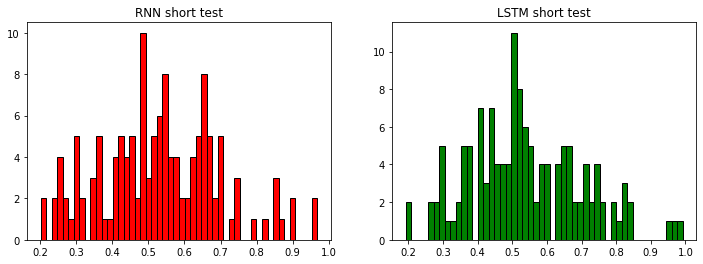

In [ ]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1)
ax1.title.set_text('RNN short test')
plt.hist(x=pd.to_numeric(rnn_short_test_df['BLEU_score']), bins=50, alpha = 1, color="red", edgecolor='black')
ax2 = plt.subplot(1,2,2)
ax2.title.set_text('LSTM short test')
plt.hist(x=pd.to_numeric(lstm_short_test_df['BLEU_score']), bins=50, alpha = 1, color="green", edgecolor='black')
plt.show()

<Figure size 432x288 with 0 Axes>

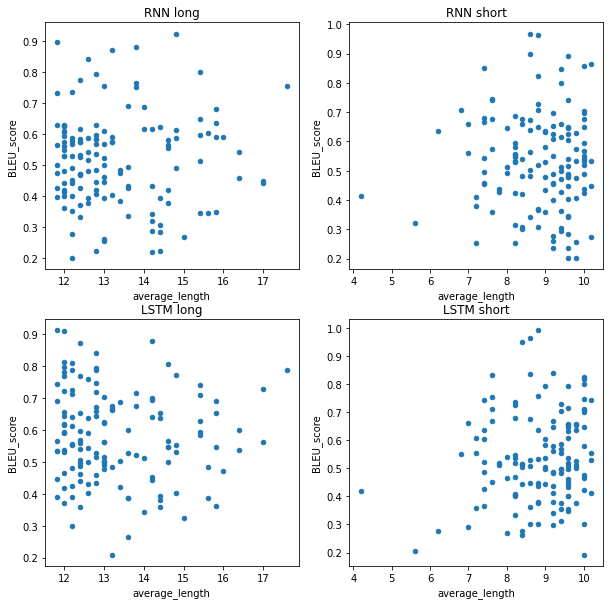

In [ ]:
plt.figure(1)
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('RNN long')
rnn_long_test_df[['average_length','BLEU_score']].apply(pd.to_numeric).plot.scatter('average_length','BLEU_score', ax=plt.gca())
plt.subplot(2,2,2)
plt.title('RNN short')
rnn_short_test_df[['average_length','BLEU_score']].apply(pd.to_numeric).plot.scatter('average_length','BLEU_score', ax=plt.gca())
plt.subplot(2,2,3)
plt.title('LSTM long')
lstm_long_test_df[['average_length','BLEU_score']].apply(pd.to_numeric).plot.scatter('average_length','BLEU_score', ax=plt.gca())
plt.subplot(2,2,4)
plt.title('LSTM short')
lstm_short_test_df[['average_length','BLEU_score']].apply(pd.to_numeric).plot.scatter('average_length','BLEU_score', ax=plt.gca())